## welch
PSD using Welch's method: Welch's method improves upon the periodogram by addressing the lack of the ensemble averaging which is present in the true PSD formula. It generalizes Barlett's method by using overlap and windowing to provide more PSD "samples" for the pseudo-ensemble average. It can be a cheap, effective method depending on the application. However, if you have a situation with closely spaced sinusoids, AR methods may be better suited. However, it does not require estimating the model order like AR methods, so if little is known about your spectrum a priori, it can be an excellent starting point.

## multitaper
The multitaper method is a non-parametric method for computing a power spectrum similar to the periodogram approach. In this method a power spectrum is computed by windowing the data and computing a Fourier transform, taking the magnitude of the result and squaring it. The multitaper method averages a pre-determined number of periodograms each computed with a different window. This method works because the selected windows have two mathematical properties. First, the windows are orthogonal. This means that each one of the periodograms is uncorrelated so averaging multiple periodograms gives an estimate with a lower variance than using just one taper. Second, the windows have the best possible concentration in the frequency domain for a fixed signal length. This means that these windows perform the best possible with respect to leakage.

## Double check spectral estimate calculation

In [1]:
%%capture
import sys
import glob, os
os.chdir('/home/m/m300878/submesoscaletelescope/notebooks/may22/')
sys.path.insert(1, '../')
from icon_smt_levels import dzw, dzt, depthc, depthi
sys.path.insert(1, '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/')
from eval_funcs import *

import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic



# load data

In [3]:
smt         = load_smt_sst()

In [223]:
    horizontal=bool(False)
    k=0
    n=1
    Lat, Lon = get_lon_lat_vertical_sst(k, n)
    for kk in np.arange(n):
        print(kk)
        lat = Lat[kk,:]
        lon = Lon[kk,:]
        ##############################################################
        ######## calculate nearest neighbour of section
        if horizontal == True: npoints = 2300
        else: npoints = 850 #exp1 = 1700 #2000ssh
        
        sname         = 'A'
        tgname        = 'SMT'
        gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
        path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
        fname_tgrid   = f'{gname}.nc'
        path_scratch  = f'/scratch/m/m300878/slices/'
        path_ckdtree  = path_scratch # where grid is stored
        if False: #Path(sec_path ).is_file():
            print ("section File exist")
            data = xr.open_dataset(sec_path)
            ickdtree = data.ickdtree_c.data
            lon_sec = data.lon_sec.data
            lat_sec = data.lat_sec.data
        else:
            print ("section file does not exist")
            if horizontal == True:
                latii = Lat[kk,:]
                dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lon[1],latii[0]], p2=[lon[0],latii[0]], npoints=npoints,
                          fname_tgrid  = fname_tgrid,
                          path_tgrid   = path_tgrid,
                          path_ckdtree = path_ckdtree,
                          sname = sname,
                          gname = gname,
                          tgname = tgname,
                          load_egrid=False,
                          load_vgrid=False,
                          )
            else:
                lonii = Lon[kk,:]
                dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lonii[0],lat[1]], p2=[lonii[0],lat[0]], npoints=npoints,
                          fname_tgrid  = fname_tgrid,
                          path_tgrid   = path_tgrid,
                          path_ckdtree = path_ckdtree,
                          sname = sname,
                          gname = gname,
                          tgname = tgname,
                          load_egrid=False,
                          load_vgrid=False,
                          )
            # check grid
            sgrid = xr.open_dataset(path_tgrid + fname_tgrid)
            grid  = sgrid.cell_area_p.compute()
            Clon  =  grid.clon * 180/np.pi
            grid  = grid.assign_coords(clon=Clon)
            Clat  =  grid.clat * 180/np.pi
            grid  = grid.assign_coords(clat=Clat)
            grid  = np.sqrt(grid.isel(cell=ickdtree))
            grid  = grid.assign_coords({"lon_sec": ("cell", lon_sec)})
            grid_smt = grid.assign_coords({"lat_sec": ("cell", lat_sec)})
            # section distance
            if horizontal == True:
                lat_min = int(grid_smt.lat_sec[0])
                d_smt_sec = (grid_smt.lon_sec[0] - grid_smt.lon_sec[1]).data *delta[lat_min]
            else:
                lat_min = int(grid_smt.lat_sec[0])
                d_smt_sec = (grid_smt.lat_sec[0] - grid_smt.lat_sec[1]).data *delta[lat_min]
            d_smt_hi_res = grid_smt.min().data
            print('max',grid_smt.max().data, 'min', grid_smt.min().data, 'distance section', d_smt_sec)
        # select data
        smt_sec = smt.isel(ncells=ickdtree)
        if horizontal == True:
            smt_sec = smt_sec.assign_coords({"clon": ("ncells", lon_sec)})
        else:
            smt_sec = smt_sec.assign_coords({"clat": ("ncells", lat_sec)})
        
        dm_smt = d_smt_sec
        # smt
        tsmt = 71*12
        #N = 984
        #l = 11
        #ll = int(N/l) +1
        ds_size = int(npoints /2) +1
        iii = 0   
        A_smt = np.zeros((1,ds_size))
        for ii in np.arange(1)[::1]:
            t_smt = smt_sec.time[tsmt].data
            y = smt_sec.isel(time=tsmt)
            cv = y.data.compute() 
            f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_smt)
            S = S.squeeze()
            A_smt[iii,:] = S
            iii += 1
        f_smt = f
        A_smt_mean = np.mean(A_smt, axis=0)
        std_smt = np.std(A_smt, axis=0)

0
section file does not exist
Saving grid file: /scratch/m/m300878/slices/SMT_nps850_68W40N_68W28N.nc
max 651.8108359301493 min 581.8692553526583 distance section 1195.9997241434153


In [224]:
ysmt = y

In [216]:
    ds          = load_satellite_sst()
    print('for satellite')
    for kk in np.arange(n):
        print(kk)
        Lat, Lon = get_lon_lat_vertical_sst(k, n)
        lat = Lat[kk,:]
        lon = Lon[kk,:]
        ds_section = ds.where((ds.lat > lat[0]) & (ds.lat < lat[1]) & (ds.lon > lon[0]) & (ds.lon < lon[1]), drop=True)
        ds_lat = int(ds_section.lat[0].data)
        if horizontal == True: 
            ds_section = ds_section.isel(lat=0)
            dm_sat = np.abs((ds_section.lon[1] - ds_section.lon[0])) * delta[ds_lat]
            ds_size = int(ds_section.lon.size /2) +1
        else: 
            ds_section = ds_section.isel(lon=0)
            dm_sat = np.abs((ds_section.lat[1] - ds_section.lat[0])) * delta[ds_lat]
            ds_size = int(ds_section.lat.size /2) +1
        
        dm_sat = dm_sat.data
        ###############################################################
        # satellite
        ds_size_sat = ds_size
        iii = 0
        t = 79
        A_sat = np.zeros((1,ds_size))
        for ii in np.arange(1)[::1]:
            #t_sat = ds_section.time[ii].data
            y = ds_section.isel(time=t).sst_night
            cv = y.data.compute() 
            nans, x= nan_helper(cv) 
            cv[nans]= np.interp(x(nans), x(~nans), cv[~nans])
            f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
            S = S.squeeze()
            A_sat[iii,:] = S
            iii += 1
        f_sat = f
        A_sat_mean = np.mean(A_sat, axis=0) # average of spectra from realisations of different timesteps
        std_sat = np.std(A_sat, axis=0)

for satellite
0


In [220]:
y

<xarray.DataArray 'sst_night' (lat: 288)>
dask.array<getitem, shape=(288,), dtype=float32, chunksize=(288,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 39.98 39.94 39.9 39.85 ... 28.15 28.1 28.06 28.02
    lon      float32 -67.98
    time     datetime64[ns] 2010-03-21
Attributes:
    long_name:    Sea surface temperature at night
    units:        degree Celsius
    valid_range:  [-200 4500]

In [230]:
#ysat = y
ysat

<xarray.DataArray 'sst_night' (lat: 288)>
dask.array<getitem, shape=(288,), dtype=float32, chunksize=(288,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 39.98 39.94 39.9 39.85 ... 28.15 28.1 28.06 28.02
    lon      float32 -67.98
    time     datetime64[ns] 2010-03-21
Attributes:
    long_name:    Sea surface temperature at night
    units:        degree Celsius
    valid_range:  [-200 4500]

In [233]:
fig = plt.figure(figsize=(12,6))
ysat.plot(x='lat')
ysmt.plot(x='clat')

# Spectral estimates with fft, periodogram, welch method, and multitaper

## calc spectra  via fft

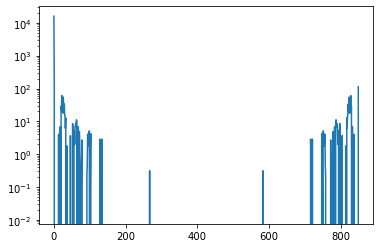

In [114]:
F =  np.fft.fft(cv, n=None, axis=- 1, norm=None) #one d discrete Fast Fourier Transfom fft
ff = np.fft.rfftfreq(n=850, d=dm_smt) # get frequencies # Return the Discrete Fourier Transform sample frequencies
plt.semilogy(F)

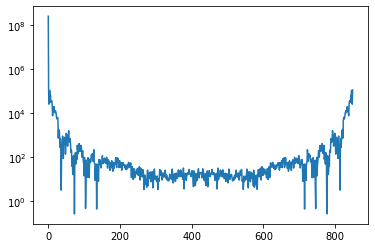

In [115]:
F = F*np.conjugate(F)
plt.semilogy(F)


In [145]:
scale = np.sqrt(scale)

In [199]:
#win, nperseg = _triage_segments(window=850, nperseg=850, input_length=x.shape[-1])
fs = 1/dm_smt
scale = 1.0/(fs*(cv.size/2)) #1.0 / (fs * (win*win).sum())


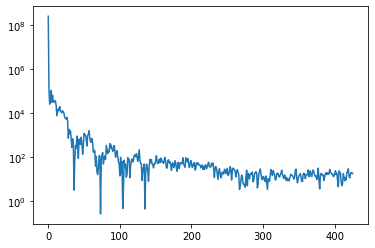

In [117]:
plt.semilogy(np.real(F))

In [205]:
!pwd

/home/m/m300878/submesoscaletelescope/notebooks/may22


#### compare to periodogram
except from a scaling factor the method are the same!

In [206]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    f, S = sg.periodogram(x,fs=1/dm_smt, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1)
    S = S.squeeze()
    plt.loglog(f, S, label='periodogram, boxcar 1 segment',  linewidth=1)
    plt.loglog(ff, F, label='fft >> F times conjugate(F)',   linewidth=1)
    plt.scatter(ff, F*scale, label='fft >> F times conjugate(F) * scale (1.0/(fs*(cv.size/2))) ', color='red',  marker='^')
    #plt.loglog(ff, diff, label='F times conjugate(F)',  linewidth=1)
    
    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density T^2/(1/m)',fontsize=15)
    plt.title(f'Periodogram equals  F times conjugate(F) * scale with F = fft(cv)',fontsize=15)
    plt.savefig('../images/fft_periodogram.png')

#### is scaling factor in periodogram dependent on length of array?
length of array and sampling frequency go into scaling >> which leads to units at y axis Variance squared over sampling frequency

In [96]:
cv.shape

(288,)

In [98]:
# FFT of satellite data
Fs =  np.fft.fft(cv, n=None, axis=- 1, norm=None) #one d discrete Fast Fourier Transfom fft
ffs = np.fft.rfftfreq(n=cv.size, d=dm_sat) # get frequencies # Return the Discrete Fourier Transform sample frequencies
Fs = Fs*np.conjugate(Fs)
Fs = Fs[:145] #* scale

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

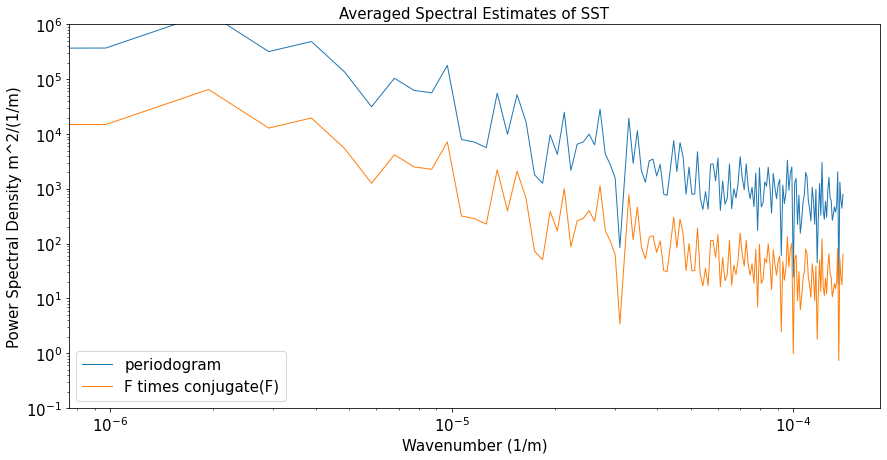

In [101]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    f, S = sg.periodogram(x,fs=1/dm_sat, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1)
    S = S.squeeze()
    plt.loglog(f, S, label='periodogram',  linewidth=1)
    plt.loglog(ffs, Fs, label='F times conjugate(F)',  linewidth=1)
    
    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

## have a closer look on welch method
periodogram is a welch method with boxcar window and full segment length = data array length

In [74]:
from scipy import signal

In [297]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    #f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_smt)
    f, S = sg.periodogram(x,fs=1/dm_smt, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1)
    S = S.squeeze()
    plt.loglog(f, S, label='smt_sst',  linewidth=1)
    #f, Pxx = signal.welch(cv-np.mean(cv), fs=1/dm_smt)
    nfft= 'None'
    axis=int(-1)
    nperseg = x.shape[axis]

    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/5), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='welch')
    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

#### influence of windows
biggest difference from boxcar to any other window

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

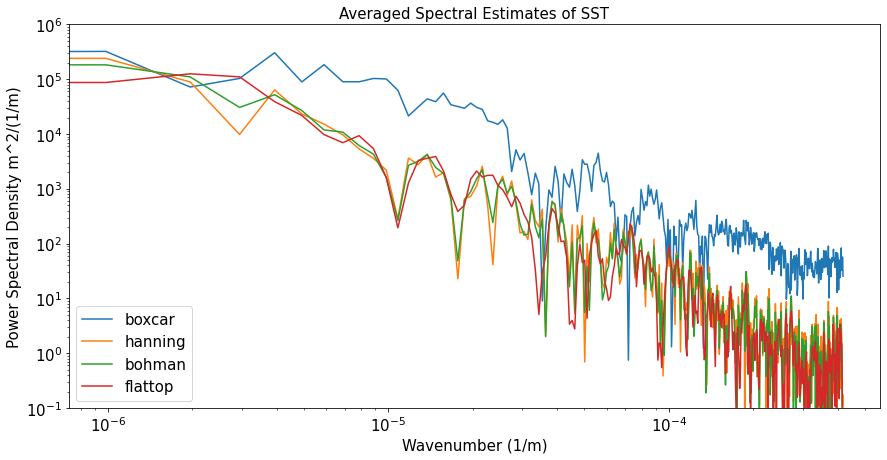

In [133]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    axis=int(-1)
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='boxcar', nperseg=int(850/1), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='boxcar')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/1), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='hanning')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='bohman', nperseg=int(850/1), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='bohman')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='flattop', nperseg=int(850/1), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='flattop')
    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

### influence of segment length in welch method
ffts of each segment are clculated, then ensamble average is taken: equals smothing, reduces amount of points

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

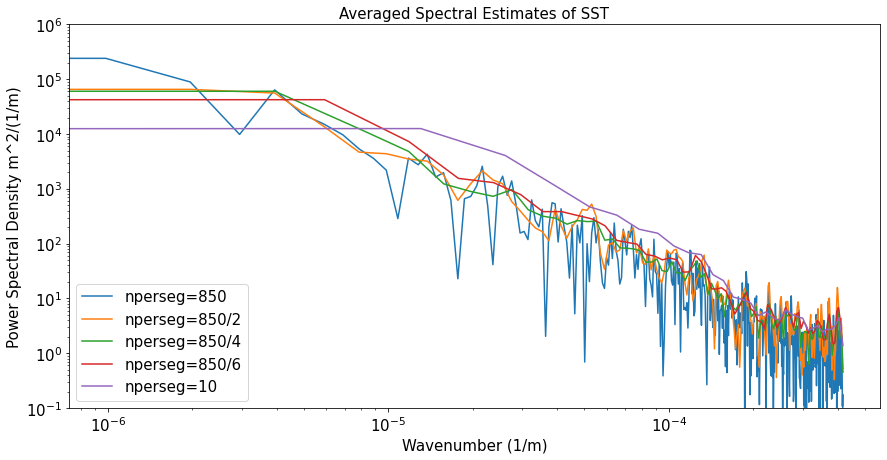

In [137]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    axis=int(-1)
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/1), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/2), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850/2')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/4), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850/4')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/6), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850/6')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=64, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=10')

    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

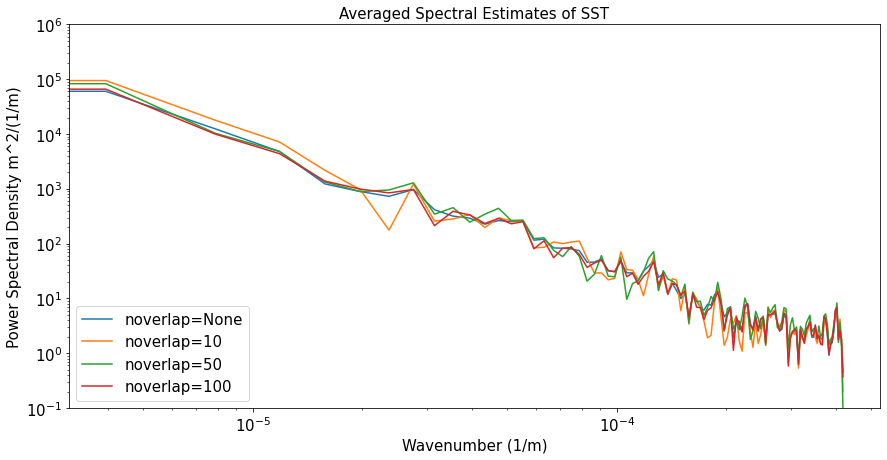

In [112]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    axis=int(-1)
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/4), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='noverlap=None')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/4), noverlap=10, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='noverlap=10')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/4), noverlap=50, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='noverlap=50')
    f, Pxx = signal.welch(x, fs=1/dm_smt, window='hanning', nperseg=int(850/4), noverlap=100, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='noverlap=100')



    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

#### and for satellite

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

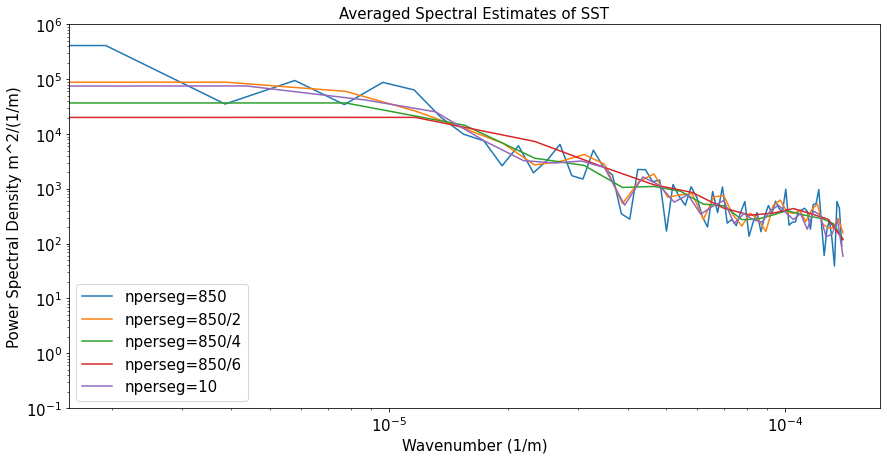

In [147]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    f = f_sat
    axis=int(-1)
    seg = 145
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=int(seg/1), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850')
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=int(seg/2), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850/2')
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=int(seg/4), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850/4')
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=int(seg/6), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=850/6')
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=64, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='nperseg=10')

    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

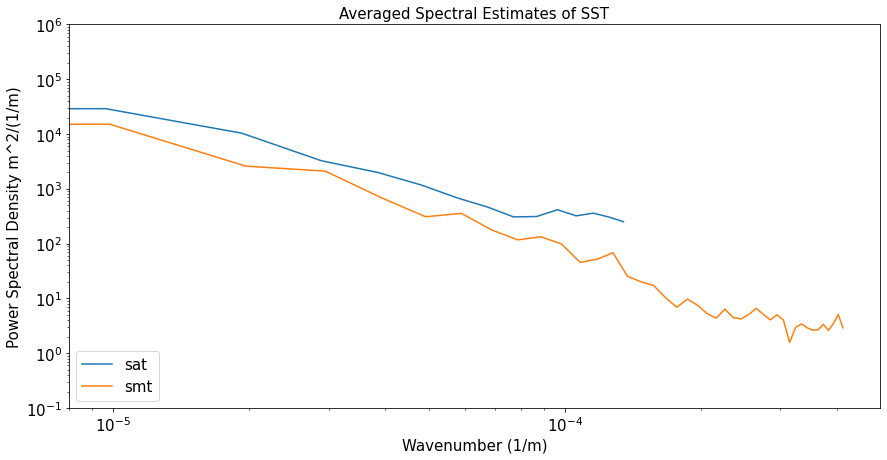

In [202]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    f = f_sat
    axis=int(-1)
    seg = 145
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=int(145/5), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='sat')
    #plt.loglog(f_sat, xfft2, label='sat')
    f, Pxx = signal.welch(ys, fs=1/dm_smt, window='hanning', nperseg=int(850/10), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='smt')
    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

## multitaper

In [228]:
import spectrum

In [247]:
P = 2
dt = dm_smt
psi, eigs = spectrum.mtm.dpss(np.size(ys), NW=P, k=2*P-1)
Zk, weights, eigenvalues = spectrum.mtm.pmtm(ys-np.mean(ys), k=2*P-1,  NFFT=np.size(ys), v=psi, e=eigs, method="unity");
S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  

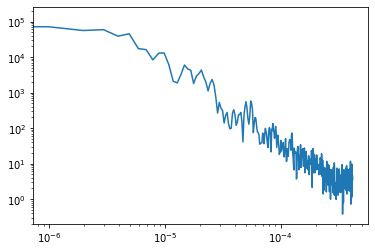

In [248]:
plt.loglog(f_smt, S[:426])

In [242]:
Pxx.shape

(129,)

In [241]:
ys.shape

(850,)

In [259]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    f = f_sat
    axis=int(-1)
    seg = 145
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(ys, fs=1/dm_smt, window='hanning', nperseg=int(850/10), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='welch')
    P = 10
    dt = dm_smt
    psi, eigs = spectrum.mtm.dpss(np.size(ys), NW=P, k=2*P-1)
    Zk, weights, eigenvalues = spectrum.mtm.pmtm(ys-np.mean(ys), k=2*P-1,  NFFT=np.size(ys), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  
    plt.loglog(f_smt, S[:426],label='multitaper')
    ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

## how to deal with data gaps
linear interpolation vs zero padding

In [289]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = cv
    f = f_sat
    axis=int(-1)
    seg = 145
    nperseg = x.shape[axis]
    f, Pxx = signal.welch(x, fs=1/dm_sat, window='hanning', nperseg=int(145/2), noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='lin inter')
    f, Pxx = signal.welch(cv0, fs=1/dm_sat, window='hanning', nperseg=int(145/2), noverlap=None, nfft=None, detrend=None, return_onesided=True, scaling='density', axis=- 1, average='mean')
    plt.loglog(f, Pxx, label='zero padding')
    #ax.set_ylim(1e-1, 1e6)
    fig.tight_layout()
    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST',fontsize=15)

Text(0.5, 1.0, 'Averaged Spectral Estimates of SST')

In [279]:
    print('for satellite')
    for kk in np.arange(n):
        print(kk)
        Lat, Lon = get_lon_lat_vertical_sst(k, n)
        lat = Lat[kk,:]
        lon = Lon[kk,:]
        ds_section = ds.where((ds.lat > lat[0]) & (ds.lat < lat[1]) & (ds.lon > lon[0]) & (ds.lon < lon[1]), drop=True)
        ds_lat = int(ds_section.lat[0].data)
        if horizontal == True: 
            ds_section = ds_section.isel(lat=0)
            dm_sat = np.abs((ds_section.lon[1] - ds_section.lon[0])) * delta[ds_lat]
            ds_size = int(ds_section.lon.size /2) +1
        else: 
            ds_section = ds_section.isel(lon=0)
            dm_sat = np.abs((ds_section.lat[1] - ds_section.lat[0])) * delta[ds_lat]
            ds_size = int(ds_section.lat.size /2) +1
        
        dm_sat = dm_sat.data
        ###############################################################
        # satellite
        ds_size_sat = ds_size
        iii = 0
        t = 79
        A_sat = np.zeros((1,ds_size))
        for ii in np.arange(1)[::1]:
            #t_sat = ds_section.time[ii].data
            y = ds_section.isel(time=t).sst_night
            cv = y.data.compute() 
            nans, x= nan_helper(cv) 
            cv-np.nanmean(cv)
            cv[nans]= 0#np.interp(x(nans), x(~nans), cv[~nans])
            f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
            S = S.squeeze()
            A_sat[iii,:] = S
            iii += 1
        f_sat = f
        A_sat_mean = np.mean(A_sat, axis=0) # average of spectra from realisations of different timesteps
        std_sat = np.std(A_sat, axis=0)

for satellite
0


## investigate theoretical spectra

In [2]:
import math

In [3]:
x = np.linspace(0,20*np.pi,10000)
x.shape

(10000,)

In [4]:
def series(x, s):
    F = 1/math.factorial(1) * 1**s * np.exp(1j * x) + 1/math.factorial(2) * 2**s * np.exp(2j * x) + 1/math.factorial(3) * 3**s * np.exp(3j * x) \
        + 1/math.factorial(4) * 4**s * np.exp(4j * x)  + 1/math.factorial(5) * 5**s * np.exp(5j * x) + 1/math.factorial(6) * 6**s * np.exp(6j * x) \
        + 1/math.factorial(7) * 7**s * np.exp(7j * x)  + 1000*noise*1/math.factorial(8) * 8**s * np.exp(8j * x) + 1/math.factorial(9) * 9**s * np.exp(9j * x) 
    return F

In [5]:
# noise
rand = np.random.rand(x.size)
noise = rand
plt.plot(rand)

In [6]:
#f3 = np.zeros(x.size)
fft2 = series(x, s=-2)
fft3 = series(x, s=-3)

In [7]:
f2, S2 = sg.periodogram(fft2-np.mean(fft2), fs=1/(x[1]-x[0]))
f3, S3 = sg.periodogram(fft3-np.mean(fft3), fs=1/(x[1]-x[0]))

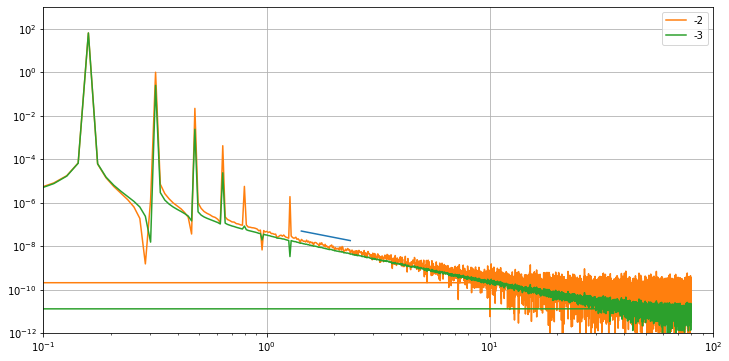

In [8]:
plt.figure(figsize=(12,6))
y2 = np.power(f2, (-2))
plt.loglog(f2[90:150], 0.0000001*y2[90:150])
plt.loglog(f2, S2, label='-2')
plt.loglog(f3, S3, label='-3')
plt.ylim(1e-12,1e3)
plt.xlim(1e-1,1e2)
plt.grid()
plt.legend()